In [18]:
# Import dependencies
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from config import api_key

## Unemployment Data by month for 2020 - 2023
- Data is sourced from the Bureau of Labor Statistics (BLS) API
- Inlcudes unemployment rate for CA, FL, NY, TX, WA and National.

In [2]:
# Set base URL
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

In [3]:
# Entering unemployment rates by states into dictionary so they can remain easily identifiable, and to also be used
# in the DataFrame to give names to columns
series_dict = {
    'LASST060000000000003': 'California',
    'LASST120000000000003': 'Florida',
    'LASST480000000000003': 'Texas',
    'LASST530000000000003': 'Washington',
    'LASST360000000000003': 'New York',
    'LNS14000000':'National'
}

# Follow specific format in BLS API format, requiring establishment of headers
headers = {'Content-type': 'application/json'}

In [4]:
# Parameters dictionary
data = json.dumps({
    'seriesid':list(series_dict.keys()), #retrieves list of the dictionary keys from series_dict
    'startyear':2020,
    'endyear':2023,
    'registrationkey':api_key})

In [5]:
# Use requests.post to submit the request to BLS API
bls = requests.post(f"{url}?",headers=headers,data=data).json()['Results']['series'] 

In [6]:
# pretty print to get a clearer look at the json
print(json.dumps(bls, indent=4, sort_keys=True))

[
    {
        "data": [
            {
                "footnotes": [
                    {}
                ],
                "period": "M12",
                "periodName": "December",
                "value": "5.1",
                "year": "2023"
            },
            {
                "footnotes": [
                    {}
                ],
                "period": "M11",
                "periodName": "November",
                "value": "5.1",
                "year": "2023"
            },
            {
                "footnotes": [
                    {}
                ],
                "period": "M10",
                "periodName": "October",
                "value": "5.1",
                "year": "2023"
            },
            {
                "footnotes": [
                    {}
                ],
                "period": "M09",
                "periodName": "September",
                "value": "5.0",
                "year": "2023"
            },
            {


In [7]:
# define function to collect all unemployment rates for 2020-2023 (stored in 'value' key)
def BLS_Unemployment(name):
    data = [] # define list to store data
    for x in range(len(bls)): # first loop through every element in bls
        if name == bls[x]['seriesID']: # if name = seriesID, then
            for y in range(len(bls[x]['data'])): # loop through the data key in that bls element
                data.append(float(bls[x]['data'][y]['value'])) # append data to list
    return data

In [8]:
# run function on each state
california = BLS_Unemployment('LASST060000000000003')
florida = BLS_Unemployment('LASST120000000000003')
texas = BLS_Unemployment('LASST480000000000003')
washington = BLS_Unemployment('LASST530000000000003')
new_york = BLS_Unemployment('LASST360000000000003')
national = BLS_Unemployment('LNS14000000')

# create list of months using list comprehension
month_string = [f"{x['year']}-{x['period'][1:]}-01" for x in bls[0]['data']]

In [9]:
# create DataFrame
unemployment_df = pd.DataFrame({
    "Month":pd.to_datetime(month_string), # cast string into datetime
    "California":california,
    "Florida":florida,
    "Texas":texas,
    "Washington":washington,
    "New York":new_york,
    "National":national
})

# Sort by ascending date, reset index
unemployment_df = (unemployment_df.sort_values("Month",ascending=True)).reset_index(drop=True)

# Display preview
unemployment_df.tail()

,Month,California,Florida,Texas,Washington,New York,National
43,2023-08-01,4.8,3.0,3.9,4.1,4.3,3.8
44,2023-09-01,5.0,3.0,3.9,4.3,4.4,3.8
45,2023-10-01,5.1,3.1,3.9,4.4,4.6,3.8
46,2023-11-01,5.1,3.1,3.9,4.4,4.6,3.7
47,2023-12-01,5.1,3.1,3.9,4.4,4.6,3.7


### Statistical summary of unemployment rates, 2020-2023

In [10]:
# Display statistical analysis of unemployment rate, by month 2020-2023
unemployment_df.iloc[:,1:].describe()

,California,Florida,Texas,Washington,New York,National
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,6.633333,4.695833,5.314583,5.479167,6.379167,5.175000
std,3.160887,2.895702,2.142080,2.670402,3.193141,2.581481
min,3.800000,2.700000,3.500000,3.700000,3.900000,3.400000
25%,4.475000,2.900000,3.900000,4.000000,4.100000,3.600000
50%,5.100000,3.250000,4.100000,4.300000,4.600000,3.800000
75%,8.325000,5.250000,6.250000,5.775000,7.950000,6.100000
max,16.100000,14.200000,12.800000,16.700000,16.700000,14.800000


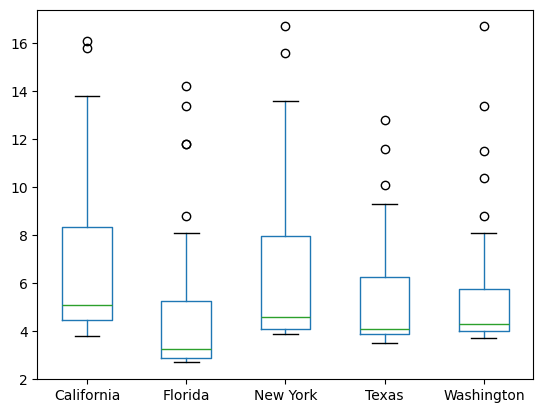

In [11]:
# Above statistical table shows that data is not normally distributed, therefore the mean is not a good summary
# of the data. We used a boxplot to confirm that.
unemployment_df.boxplot(['California','Florida','New York','Texas','Washington'], grid=False) 
plt.show()

In [12]:
# We opted for the median to get a summary of the data
unemployment_df.iloc[:,1:].median()

California    5.10
Florida       3.25
Texas         4.10
Washington    4.30
New York      4.60
National      3.80
dtype: float64

In [13]:
# Calculate differences between months, insert into new DataFrame
differences_in_unemployment = unemployment_df.iloc[:,1:].diff(periods=1,axis=0)

# Add months column, reorganize columns, cast months as datetime
differences_in_unemployment['Month'] = unemployment_df['Month'].values.tolist()
differences_in_unemployment = differences_in_unemployment[['Month','California','Florida','Texas','Washington','New York','National']]
differences_in_unemployment = differences_in_unemployment.astype({'Month':'datetime64[ns]'})

# Fill NaN (first row) with zeroes.
differences_in_unemployment = differences_in_unemployment.fillna(0)

### Should we omit below cell?

In [14]:
# Show statistical analysis of percent change calcs between states
differences_in_unemployment.iloc[:,1:].describe()

,California,Florida,Texas,Washington,New York,National
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.016667,0.002083,0.008333,0.014583,0.010417,0.002083
std,1.636204,1.500849,1.218795,1.814480,1.775032,1.618048
min,-2.000000,-3.000000,-1.500000,-3.300000,-3.100000,-2.200000
25%,-0.400000,-0.200000,-0.200000,-0.200000,-0.300000,-0.225000
50%,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000
75%,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.600000,9.300000,7.800000,11.500000,11.400000,10.400000


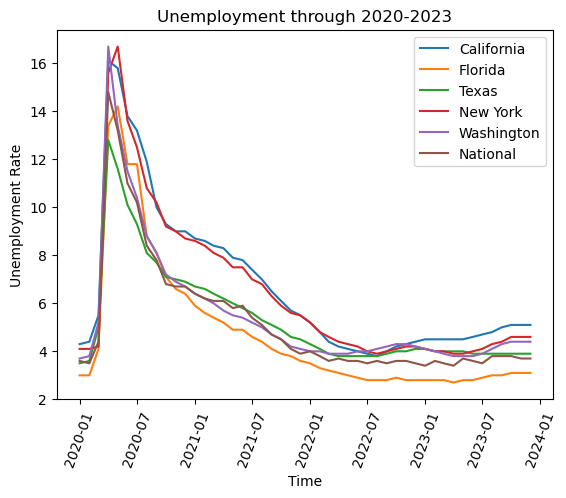

In [16]:
# Plot based on unemployment_df
plt.plot(unemployment_df['Month'],unemployment_df['California'])
plt.plot(unemployment_df['Month'],unemployment_df['Florida'])
plt.plot(unemployment_df['Month'],unemployment_df['Texas'])
plt.plot(unemployment_df['Month'],unemployment_df['New York'])
plt.plot(unemployment_df['Month'],unemployment_df['Washington'])
plt.plot(unemployment_df['Month'],unemployment_df['National'])
plt.legend(['California','Florida','Texas','New York','Washington','National'])
plt.title('Unemployment through 2020-2023')
plt.ylabel("Unemployment Rate")
plt.xlabel("Time")
plt.xticks(rotation=70)

# Save graph as png file
plt.savefig(f'output/Unemployment_Rates_2020-2023.png')

# Display chart
plt.show()

In [17]:
# Export unemployment_df into a csv
unemployment_df.to_csv("output/unemployment_rates_2020-2023.csv",index=False)

# Quarterly GDP for CA, FL, NY, TX, WA and US - 2020-2023
- Data sourced from U.S. Department of Commerce - Bureau of Economic Analysis
- https://www.bea.gov/

In [19]:
# Read CSV files
gdp_csv = ("../Data/GDP_2020-2023_quarterly.csv")
gdp_df = pd.read_csv(gdp_csv)

industry_csv = ("../Data/Quarterly_GDP_Industry_By_State_2020-2023.csv")
industry_df = pd.read_csv(industry_csv, skiprows=3)

In [20]:
# Clear blank spaces in cells so we can cast values to float64
for column in gdp_df.columns:
    gdp_df[column] = gdp_df[column].str.strip()
# Remove commas from US - Washington columns, cast as float
for column in (gdp_df.columns)[1:]:
    gdp_df[column] = gdp_df[column].str.replace(',','').astype(float)

In [21]:
# Rename columns to remove extra spaces
gdp_df = gdp_df.rename(columns = {' United States ':'United States',' California ':'California',' Florida ':'Florida',
                         ' New York ':'New York',' Texas ':'Texas',' Washington ':'Washington'})

In [22]:
# Display preview (values are presented in millions of dollars)
gdp_df

,Quarter,United States,California,Florida,New York,Texas,Washington
0,2020:Q1,21727657.0,3118522.7,1152589.9,1821606.8,1840874.8,619251.6
1,2020:Q2,19935444.0,2871237.9,1066451.9,1660253.4,1676440.7,584351.8
2,2020:Q3,21684551.0,3126987.5,1166652.6,1790068.9,1819976.6,637585.2
3,2020:Q4,22068767.0,3190272.4,1182323.3,1821550.1,1871282.8,639342.9
4,2021:Q1,22656793.0,3279904.9,1220392.1,1840547.4,1957009.4,662224.7
5,2021:Q2,23368861.0,3376467.2,1276526.3,1897462.8,2045172.0,685605.8
6,2021:Q3,23921991.0,3465519.5,1320150.4,1938860.2,2120880.3,691182.0
7,2021:Q4,24777038.0,3573941.6,1377455.9,2016782.7,2232827.4,711796.8
8,2022:Q1,25215491.0,3591071.1,1400023.1,2025436.9,2323836.7,720503.4
9,2022:Q2,25805791.0,3641685.3,1442829.2,2029181.6,2433824.2,732415.3


In [23]:
# Statistical analysis of GDP figures
gdp_df.iloc[:,1:].describe()

,United States,California,Florida,New York,Texas,Washington
count,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01,16.000000
mean,2.469072e+07,3.507877e+06,1.376682e+06,1.980388e+06,2.227977e+06,714652.306250
std,2.575257e+06,3.179839e+05,1.845896e+05,1.620174e+05,3.241438e+05,74126.124362
min,1.993544e+07,2.871238e+06,1.066452e+06,1.660253e+06,1.676441e+06,584351.800000
25%,2.250979e+07,3.257497e+06,1.210875e+06,1.835812e+06,1.935578e+06,656504.250000
50%,2.499626e+07,3.582506e+06,1.388740e+06,2.021110e+06,2.278332e+06,716150.100000
75%,2.684180e+07,3.742068e+06,1.537711e+06,2.100794e+06,2.518272e+06,772876.500000
max,2.829697e+07,3.936165e+06,1.642249e+06,2.207141e+06,2.647608e+06,831911.300000


In [24]:
# Calculate percent change for each column
gdp_df['US % Change'] = gdp_df['United States'].pct_change()
gdp_df['CA % Change'] = gdp_df['California'].pct_change()
gdp_df['FL % Change'] = gdp_df['Florida'].pct_change()
gdp_df['NY % Change'] = gdp_df['New York'].pct_change()
gdp_df['TX % Change'] = gdp_df['Texas'].pct_change()
gdp_df['WA % Change'] = gdp_df['Washington'].pct_change()

# Reorganize columns
gdp_pc = gdp_df[['Quarter','CA % Change','FL % Change','NY % Change','TX % Change','WA % Change','US % Change']]

# Drop first row (NaN)
gdp_pc = gdp_pc.iloc[1:,:]

# Display dataframe
gdp_pc

,Quarter,CA % Change,FL % Change,NY % Change,TX % Change,WA % Change,US % Change
1,2020:Q2,-0.079295,-0.074734,-0.088578,-0.089324,-0.056358,-0.082485
2,2020:Q3,0.089073,0.093957,0.078190,0.085619,0.091098,0.087739
3,2020:Q4,0.020238,0.013432,0.017587,0.028191,0.002757,0.017718
4,2021:Q1,0.028096,0.032198,0.010429,0.045812,0.035790,0.026645
5,2021:Q2,0.029441,0.045997,0.030923,0.045050,0.035307,0.031428
6,2021:Q3,0.026374,0.034174,0.021817,0.037018,0.008133,0.023670
7,2021:Q4,0.031286,0.043408,0.040190,0.052783,0.029825,0.035743
8,2022:Q1,0.004793,0.016383,0.004291,0.040760,0.012232,0.017696
9,2022:Q2,0.014094,0.030575,0.001849,0.047330,0.016533,0.023410
10,2022:Q3,0.012964,0.032660,0.017053,0.018029,0.023216,0.018066


In [25]:
# Statistical analysis of percent change in GDP, quarterly 2020 - 2023
gdp_pc.describe()

,CA % Change,FL % Change,NY % Change,TX % Change,WA % Change,US % Change
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.016164,0.024427,0.013428,0.025211,0.020272,0.018297
std,0.033254,0.034016,0.033876,0.038029,0.029318,0.033475
min,-0.079295,-0.074734,-0.088578,-0.089324,-0.056358,-0.082485
25%,0.008798,0.017342,0.007364,0.014555,0.014382,0.016841
50%,0.016615,0.025752,0.015604,0.028191,0.020151,0.018066
75%,0.027235,0.033417,0.020123,0.045431,0.028177,0.025157
max,0.089073,0.093957,0.078190,0.085619,0.091098,0.087739


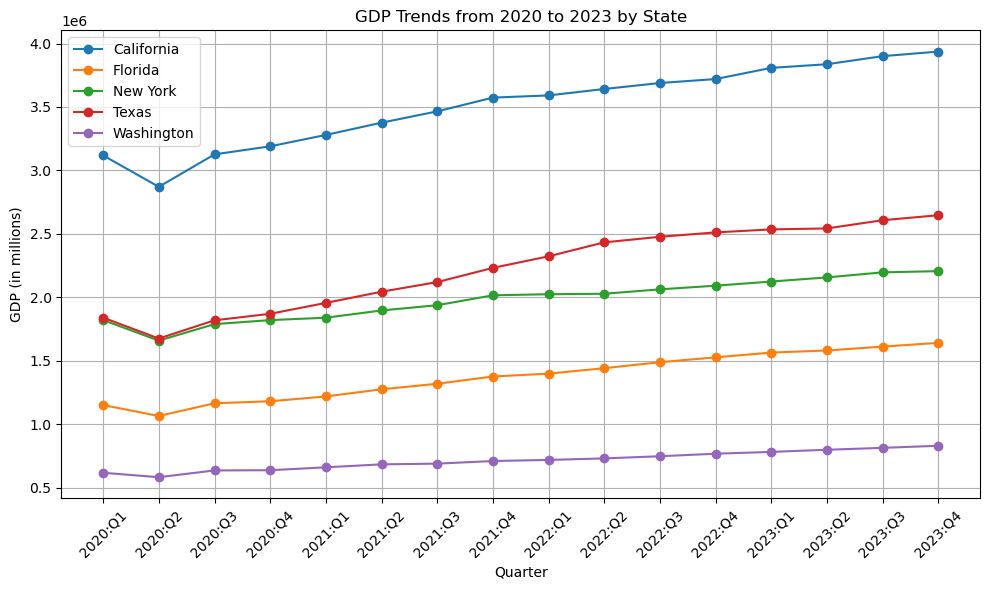

In [26]:
# Create line plots for each state from 2020 to 2023
plt.figure(figsize=(10, 6))
for state in ['California', 'Florida', 'New York', 'Texas', 'Washington']:
    plt.plot(gdp_df['Quarter'], gdp_df[state], marker='o', label=state)

# Add plot details
plt.title("GDP Trends from 2020 to 2023 by State")
plt.xlabel("Quarter")
plt.ylabel("GDP (in millions)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save figure
plt.savefig("output/GDP_2020-2023.png")

# Display the plot
plt.show()

### Should we omit below cell?

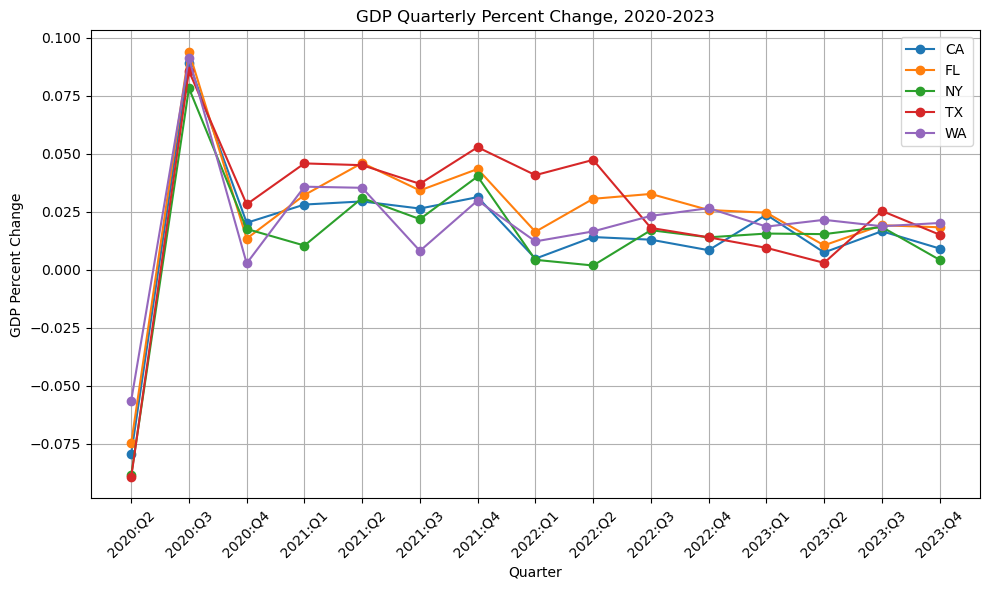

In [27]:
# Create line plots for each state from 2020 to 2023
plt.figure(figsize=(10, 6))
for state in ['CA', 'FL', 'NY', 'TX', 'WA']:
    plt.plot(gdp_df['Quarter'], gdp_df[f'{state} % Change'], marker='o', label=state)

# Add plot details
plt.title("GDP Quarterly Percent Change, 2020-2023")
plt.xlabel("Quarter")
plt.ylabel("GDP Percent Change")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save figure
plt.savefig("output/GDP_Percent_Change_2020-2023.png")

# Display the plot
plt.show()

## Industry breakdown of GDP

In [28]:
# Preview dataframe
industry_df

,GeoFips,GeoName,LineCode,Description,2020:Q1,2020:Q2,2020:Q3,2020:Q4,2021:Q1,2021:Q2,2021:Q3,2021:Q4,2022:Q1,2022:Q2,2022:Q3,2022:Q4,2023:Q1,2023:Q2,2023:Q3,2023:Q4
0,6000,California,1.0,All industry total,3118522.7,2871237.9,3126987.5,3190272.4,3279904.9,3376467.2,3465519.5,3573941.6,3591071.1,3641685.3,3688897.5,3720008.9,3808244.2,3836679.8,3900426.7,3936165.1
1,6000,California,2.0,Private industries,2759259.4,2521761.5,2768349.1,2833621.2,2915463.2,3009396.7,3091048.3,3199317.3,3216875.9,3266071.4,3305247.5,3333024.5,3409034.0,3433178.7,3489861.2,3520636.1
2,6000,California,3.0,"Agriculture, forestry, fishing and hunting",35105.6,38280.5,40365.0,42531.6,37807.2,40639.4,43821.9,51268.9,46088.0,46381.2,47584.0,52614.1,46792.6,49548.2,48382.0,48126.3
3,6000,California,6.0,"Mining, quarrying, and oil and gas extra...",8013.2,5465.3,7760.4,7618.3,8860.1,9300.3,9973.1,11773.2,11345.0,12969.3,11385.7,11175.2,9863.8,9616.0,10496.2,10167.1
4,6000,California,10.0,Utilities,37989.9,41506.4,44531.2,45383.0,46841.4,45116.5,46683.7,50872.1,47474.8,56451.0,58336.1,53701.3,54601.4,51631.0,52667.4,51391.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,53000,Washington,86.0,State and local,58066.9,55044.3,55896.6,55934.1,58305.5,58463.7,59150.5,58469.5,62008.3,61255.9,62264.5,64385.7,64779.9,66290.2,66964.9,67924.3
135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,Legend/Footnotes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137,"1. For levels: millions of dollars, seasonally...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Remove NaN values (last 2 rows)
industry_df = industry_df.dropna()

# Remove blank spaces that are included in strings
industry_df = industry_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Remove aggregate descriptions
industry_df = industry_df[(industry_df['Description'] != 'Private industries') & (industry_df['Description'] != 'All industry total')
& (industry_df['Description'] != 'Manufacturing') & (industry_df['Description'] != 'Government and government enterprises')]

# Rename GeoName to State
industry_df = industry_df.rename(columns = {'GeoName':'State'})

# Drop 'GeoFips' and 'LineCode' columns
industry_df = industry_df.drop(columns=['GeoFips','LineCode'])

# Preview DataFrame
industry_df.head()

,State,Description,2020:Q1,2020:Q2,2020:Q3,2020:Q4,2021:Q1,2021:Q2,2021:Q3,2021:Q4,2022:Q1,2022:Q2,2022:Q3,2022:Q4,2023:Q1,2023:Q2,2023:Q3,2023:Q4
2,California,"Agriculture, forestry, fishing and hunting",35105.6,38280.5,40365.0,42531.6,37807.2,40639.4,43821.9,51268.9,46088.0,46381.2,47584.0,52614.1,46792.6,49548.2,48382.0,48126.3
3,California,"Mining, quarrying, and oil and gas extraction",8013.2,5465.3,7760.4,7618.3,8860.1,9300.3,9973.1,11773.2,11345.0,12969.3,11385.7,11175.2,9863.8,9616.0,10496.2,10167.1
4,California,Utilities,37989.9,41506.4,44531.2,45383.0,46841.4,45116.5,46683.7,50872.1,47474.8,56451.0,58336.1,53701.3,54601.4,51631.0,52667.4,51391.8
5,California,Construction,128749.6,118677.7,127896.8,128552.6,131602.0,131039.0,129881.6,133164.1,141077.8,138948.3,142382.7,146792.0,145337.2,149109.6,152722.6,155291.9
7,California,Durable goods manufacturing,195565.5,186665.8,214693.9,211828.4,223020.1,226828.6,216469.4,225510.7,230335.4,231225.2,230371.2,233509.7,241779.1,243951.8,250297.6,253739.3


In [30]:
# Define lists for new dataframe to capture quarter, state, description and GDP output values - top 3 values in GDP
# for all states in each quarter
state = []
output = []
desc = []
quart = []

# Start with a for loop for the year 2020
for sta in industry_df['State'].unique().tolist():
    for i in range(1,5):
        output.extend(industry_df[industry_df['State']==sta].loc[:,f'2020:Q{i}'].values.tolist())
        state.extend(industry_df[industry_df['State']==sta].loc[:,'State'].values.tolist())
        desc.extend(industry_df[industry_df['State']==sta].loc[:,'Description'].values.tolist())
        quart.extend([f'2020:Q{i}']*23)
        

# Then loop through the 2021
for sta in industry_df['State'].unique().tolist():
    for i in range(1,5):
        output.extend(industry_df[industry_df['State']==sta].loc[:,f'2021:Q{i}'].values.tolist())
        state.extend(industry_df[industry_df['State']==sta].loc[:,'State'].values.tolist())
        desc.extend(industry_df[industry_df['State']==sta].loc[:,'Description'].values.tolist())
        quart.extend([f'2021:Q{i}']*23)
        

# Then loop through the 2022
for sta in industry_df['State'].unique().tolist():
    for i in range(1,5):
        output.extend(industry_df[industry_df['State']==sta].loc[:,f'2022:Q{i}'].values.tolist())
        state.extend(industry_df[industry_df['State']==sta].loc[:,'State'].values.tolist())
        desc.extend(industry_df[industry_df['State']==sta].loc[:,'Description'].values.tolist())
        quart.extend([f'2022:Q{i}']*23)
        

# Then loop through the 2023
for sta in industry_df['State'].unique().tolist():
    for i in range(1,5):
        output.extend(industry_df[industry_df['State']==sta].loc[:,f'2023:Q{i}'].values.tolist())
        state.extend(industry_df[industry_df['State']==sta].loc[:,'State'].values.tolist())
        desc.extend(industry_df[industry_df['State']==sta].loc[:,'Description'].values.tolist())
        quart.extend([f'2023:Q{i}']*23)
        



# Create new DataFrame with lists
industry_2 = pd.DataFrame({"Quarter":quart,
                   "State":state,
                   "Description":desc,
                   "GDP Output":output})



In [31]:
# Display preview new dataframe
industry_2.head()

,Quarter,State,Description,GDP Output
0,2020:Q1,California,"Agriculture, forestry, fishing and hunting",35105.6
1,2020:Q1,California,"Mining, quarrying, and oil and gas extraction",8013.2
2,2020:Q1,California,Utilities,37989.9
3,2020:Q1,California,Construction,128749.6
4,2020:Q1,California,Durable goods manufacturing,195565.5


In [32]:
# Define funciton that will plot industry GDP by state for years 2020 - 2023

def gdp_sectors(state):

    # Filter df to state, groupby Description, get sum of GDP, insert into list for x values
    values = list(industry_2[industry_2['State']== state].groupby(['Description']).sum()['GDP Output'].sort_values(ascending=False))
    # insert keys of groupby project into list for y values
    y = list(industry_2[industry_2['State']== state].groupby(['Description']).sum()['GDP Output'].sort_values(ascending=False).keys())

    # Set figure size
    fig, ax = plt.subplots(figsize =(10, 8))

    # Horizontal bar plot
    ax.barh(y,values)

    # Remove x, y ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # Add grid
    plt.grid(axis = 'x')

    # Invert y axis
    ax.invert_yaxis()

    # Additional formatting
    plt.xlabel('GDP (in Millions of Dollars)')
    plt.ylabel('Sector')
    plt.title(f'{state} GDP Contribution by Sector in Millions of Dollars, 2020-2023')
    plt.xticks(rotation=40)
    plt.ticklabel_format(style='plain', axis='x')

    # Save plot as png
    plt.savefig(f'output/GDP_By_Inudstry_2020-2023_{state}.png')

    # Display plot
    plt.show()

For plotting section in cell above, we used the website "geeksforgeeks" as a reference. Direct page to reference: https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

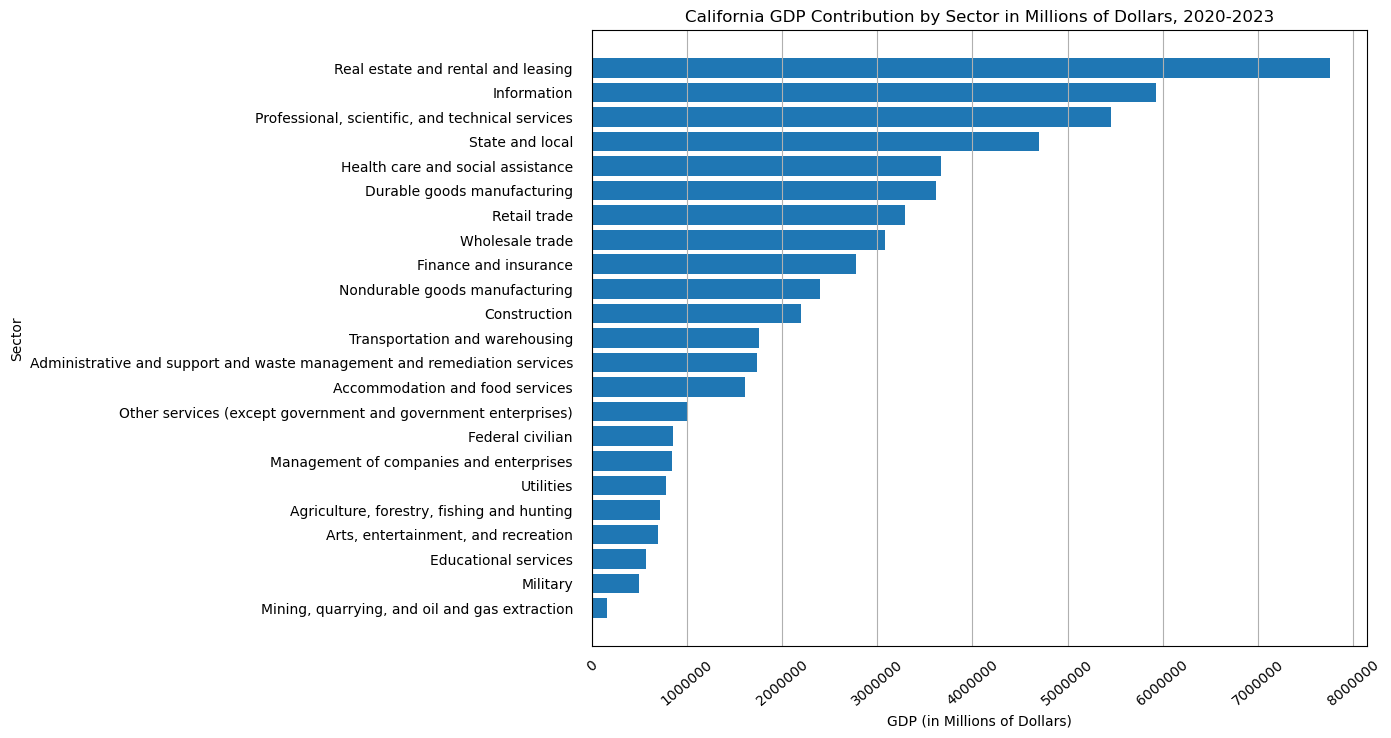

In [33]:
gdp_sectors('California')

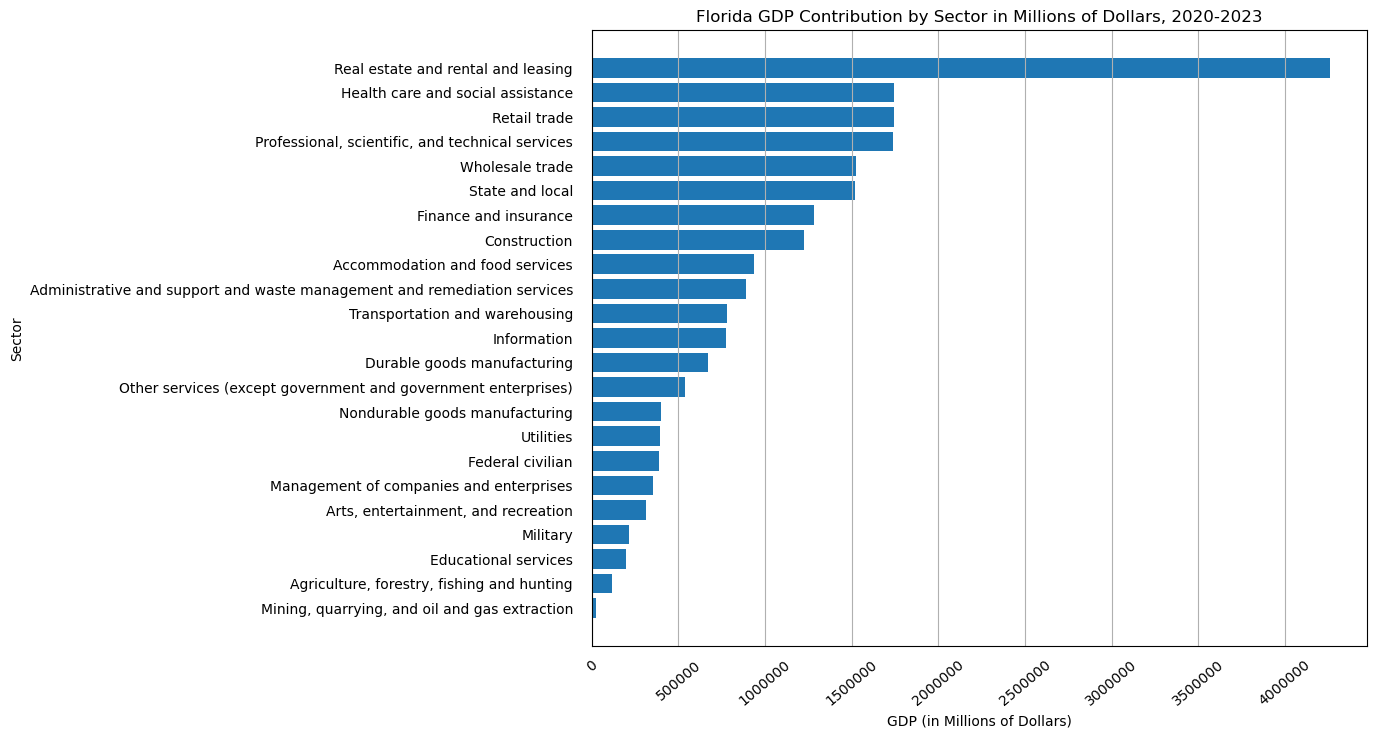

In [34]:
gdp_sectors('Florida')

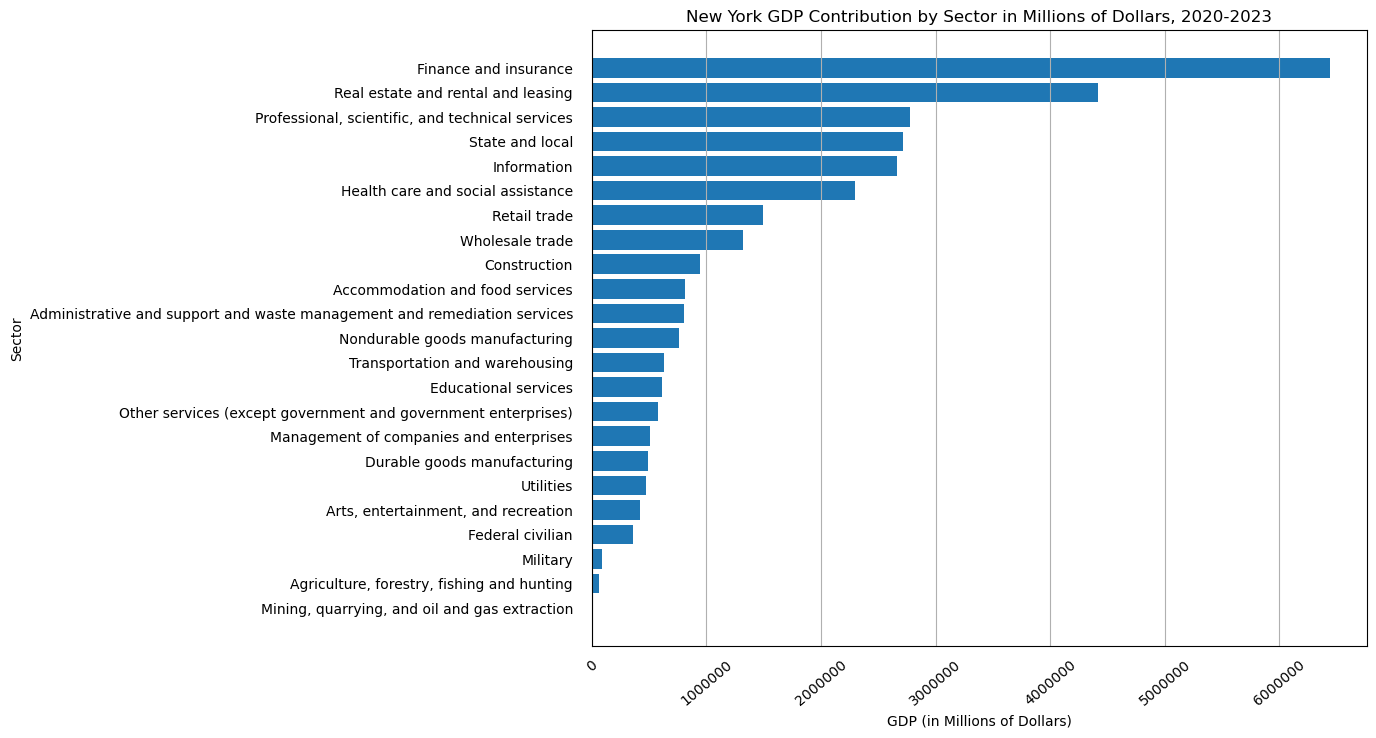

In [35]:
gdp_sectors('New York')

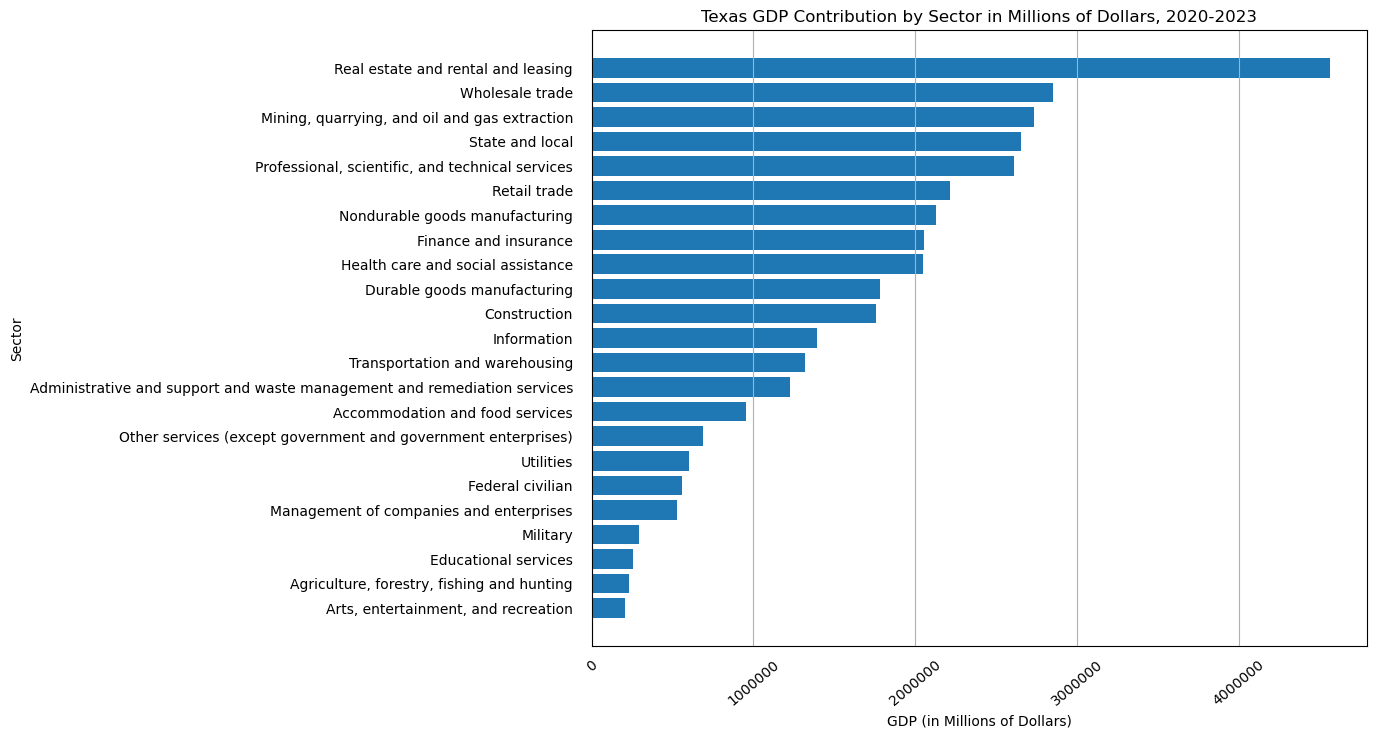

In [36]:
gdp_sectors('Texas')

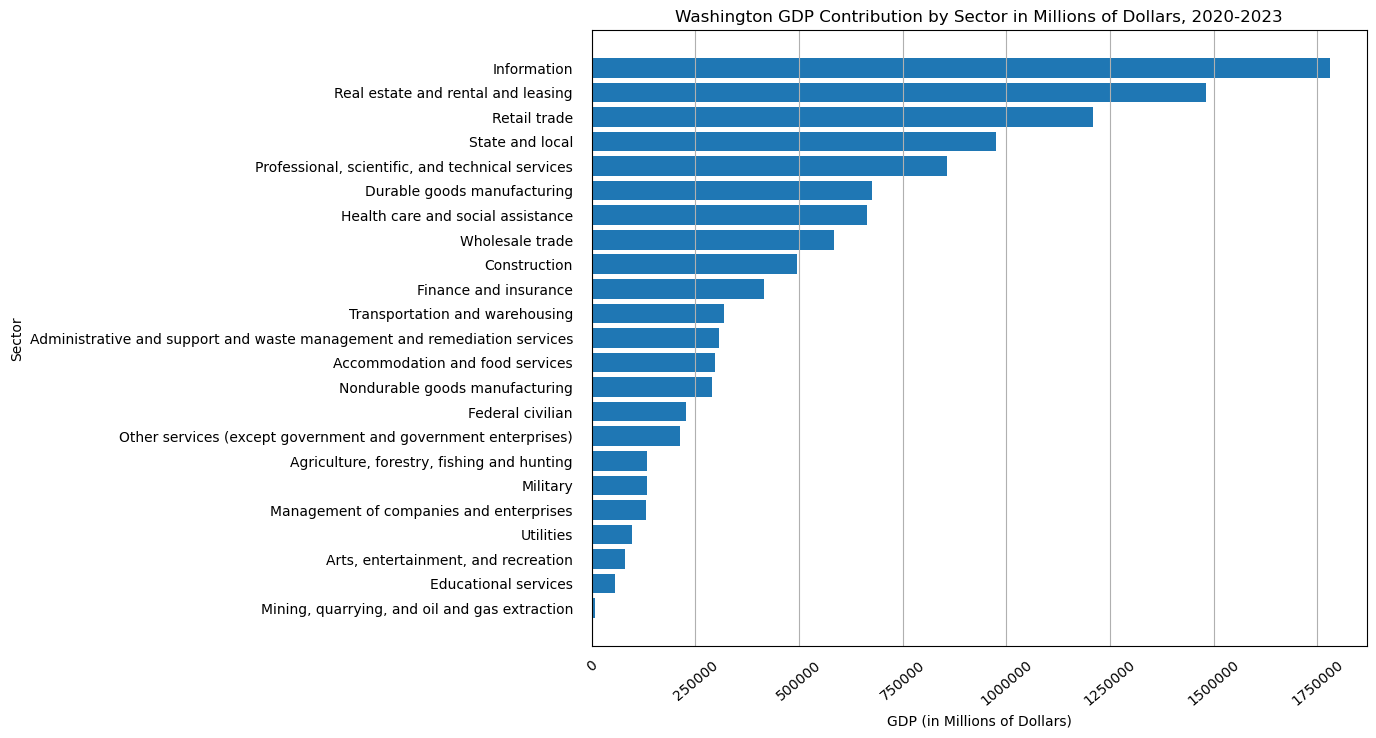

In [37]:
gdp_sectors('Washington')

## Is there a linear relationship between GDP and Unemployment?
In this section, we want to examine the relationships between GDP and Unemployment in each state through 2020 - 2023. We acknowledge that this is a very limited data set since we're only able to source quarterly data for most of the variables we're examining.

In [38]:
# Import and read unemployment csv file into dataframe
unemployment_csv = ("output/unemployment_rates_2020-2023.csv")
unemployment_df = pd.read_csv(unemployment_csv)
unemployment_df = unemployment_df.astype({'Month':'datetime64[ns]'})
unemployment_df = unemployment_df.set_index("Month")

# Resample data monthly data into quarterly to do a scatterplot with GDP; Using median since the data is not regularly
# distributed
quarterly_df = unemployment_df.resample('QE').mean()

# Preview df
quarterly_df.head()

,California,Florida,Texas,Washington,New York,National
Month,,,,,,
2020-03-31,4.733333,3.366667,4.033333,4.233333,4.133333,3.833333
2020-06-30,15.233333,13.133333,11.500000,13.866667,15.300000,13.000000
2020-09-30,11.700000,9.566667,8.366667,9.100000,11.166667,8.800000
2020-12-31,9.100000,6.700000,7.000000,6.933333,8.966667,6.733333
2021-03-31,8.566667,5.633333,6.566667,6.200000,8.366667,6.233333


In [39]:
# Define function to plot linear regression of quarterly state GDP vs quarterly state unemployment rate, 2020-2023
def gdp_regress(state):
    # Set y and x axes
    x = gdp_df[state]
    y = quarterly_df[state]

    # Create scatter plot
    plt.scatter(x,y)
    # Calculate linear regression
    (slope,intercept,rvalue,pvalue,stderr) = linregress(x,y)
    regress_values = x * slope + intercept

    # Create string of line equation
    line_eq = f"y = {str(round(slope,2))}x + {str(round(intercept,2))}"

    # Plot the line
    plt.plot(x,regress_values,"r-")

    # Format graphs
    plt.ylabel('Unemployment Rate')
    plt.xlabel('GDP (millions)')
    plt.title(f'{state} GDP vs Unemployment Rate, 2020-2023')
    plt.annotate(line_eq,xy=(gdp_df[state].min(),quarterly_df[state].min()),fontsize=15,color="red")

    # Print pearson coefficient
    print(f"The r^2 value is: {rvalue**2}")

    # Save the graph as a png
    plt.savefig(f'output/Linear_Unemployment_GDP_{state}') # save fig as png
    
    # Display plot
    plt.show()

The r^2 value is: 0.6534955455640314


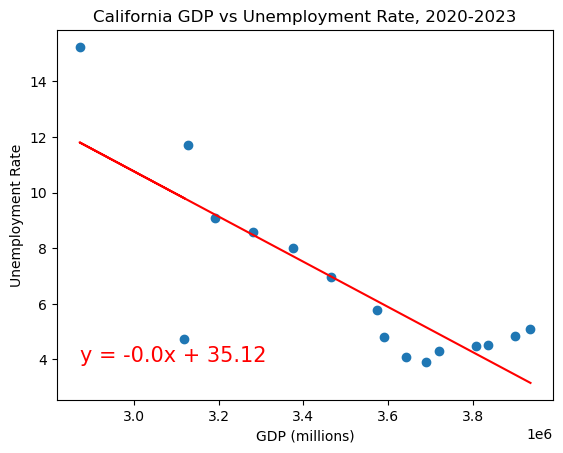

In [40]:
gdp_regress('California')

The r^2 value is: 0.635150687176309


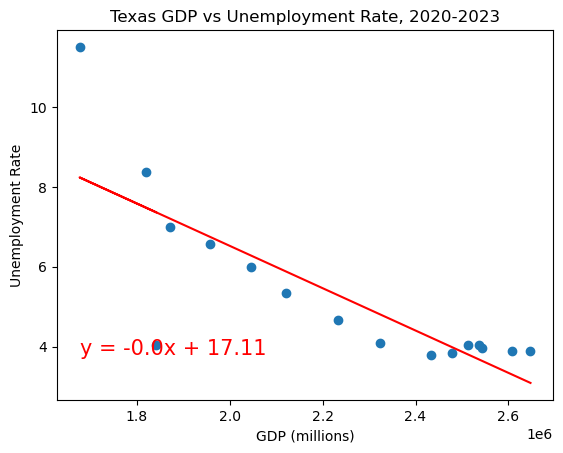

In [41]:
gdp_regress('Texas')

The r^2 value is: 0.5757017087603803


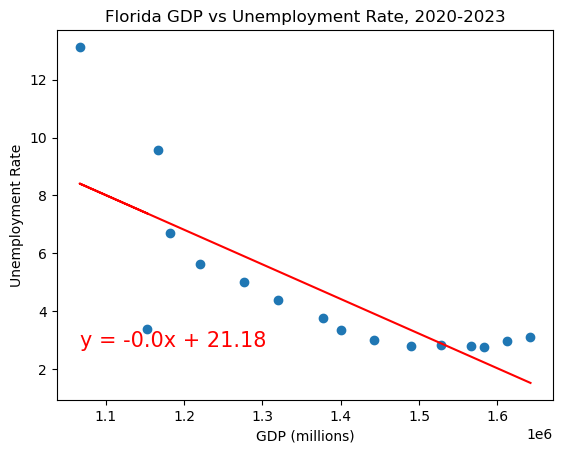

In [42]:
gdp_regress('Florida')

The r^2 value is: 0.6839234732683744


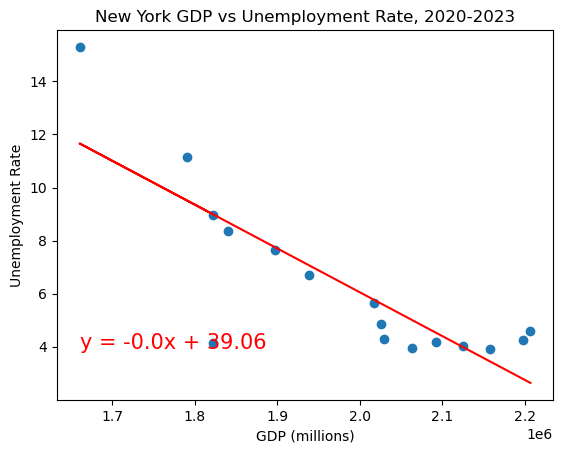

In [44]:
gdp_regress('New York')

The r^2 value is: 0.4826516178704578


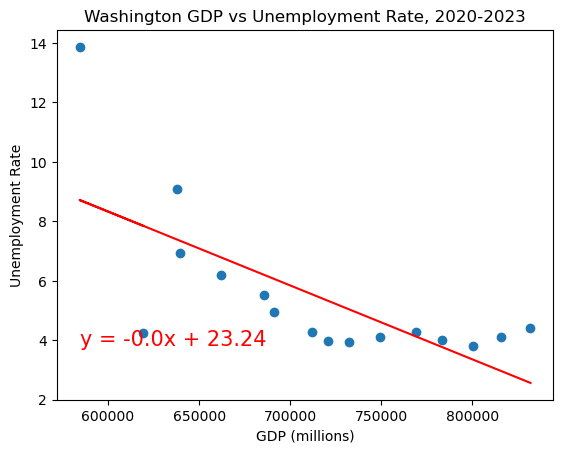

In [43]:
gdp_regress('Washington')

# Personal Income per Capita and Poverty Rate
- Personal Income was sourced from Dept of Commerce - Bureau of Economic Analysis
- Poverty Rate was sourced from the Census webiste

In [45]:
# Read CSV files
# Poverty rate and population estimates. This is yearly data
poverty_data = ("../Data/Poverty_Data_Census_2020-2023.csv")
poverty_df = pd.read_csv(poverty_data)

# Per Capita Personal Income - This is quarterly data
personal_income = ("../Data/Quarterly_Per_Capita_Personal_Income_2020-2023.csv")
income_df = pd.read_csv(personal_income)


In [46]:
# Preview income_df
income_df

,GeoFips,GeoName,2020:Q1,2020:Q2,2020:Q3,2020:Q4,2021:Q1,2021:Q2,2021:Q3,2021:Q4,2022:Q1,2022:Q2,2022:Q3,2022:Q4,2023:Q1,2023:Q2,2023:Q3,2023:Q4
0,0,United States,56595,60862,59742,59271,66742,63332,63609,64106,64766,65577,66822,67766,68684,69519,70140,70851
1,6000,California,66330,70512,72381,71363,78904,75699,76411,76261,75718,76032,77316,78658,79882,80970,81711,82408
2,12000,Florida,54623,58120,56829,56522,64412,60965,61225,62132,62542,63850,65426,66445,67737,68450,68870,69674
3,19000,Iowa,50072,54981,52333,53060,60425,57884,57479,57112,59942,61034,62515,62768,62417,62421,63021,63219
4,36000,New York,67345,72304,71836,69991,78487,74921,75068,75458,75781,76635,77936,79510,80213,82041,83247,83753
5,48000,Texas,53152,56358,55101,54613,62031,58871,59305,60504,61157,62427,63808,64522,65560,65860,66433,67093
6,50000,Vermont,55786,61509,57785,57243,64184,59713,59665,59933,61980,63041,64067,65408,65953,66818,66938,67991
7,53000,Washington,65145,69670,68225,67770,75634,72903,72680,73284,74232,74885,76222,77430,79061,80727,81359,82531


In [47]:
# Clean up income_df

# Remove GeoFips column
income_df = income_df.iloc[:,1:]

# Remove extra Vermont and Iowa from dataframe
income_df = income_df[(income_df['GeoName'] != 'Iowa') & (income_df['GeoName'] != 'Vermont')]

# Transpose the DataFrame
income_df = income_df.T

# Rename columns to country names
income_df = income_df.rename(columns=income_df.iloc[0])

# Reset Index
income_df = income_df.reset_index(names="Quarters")

# Remove first row
income_df = income_df.iloc[1:,:]

# Year splice + quarter splice loop
year = []
quarter = []
for i in income_df.iloc[:,0]:
    year.append(i[:4])
    quarter.append(i[5:])

# Insert columns into dataframe
income_df.insert(1,"Quarter",quarter)
income_df.insert(2,"Year",year)


# Preview income_df
income_df.head()

,Quarters,Quarter,Year,United States,California,Florida,New York,Texas,Washington
1,2020:Q1,Q1,2020,56595,66330,54623,67345,53152,65145
2,2020:Q2,Q2,2020,60862,70512,58120,72304,56358,69670
3,2020:Q3,Q3,2020,59742,72381,56829,71836,55101,68225
4,2020:Q4,Q4,2020,59271,71363,56522,69991,54613,67770
5,2021:Q1,Q1,2021,66742,78904,64412,78487,62031,75634


In [48]:
# Cast all columns, from US to WA, as float
for column in (income_df.columns)[3:]:
    income_df[column] = income_df[column].astype(float)

In [49]:
# Statistical summary of income
income_df.describe()

,United States,California,Florida,New York,Texas,Washington
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,64899.000000,76284.750000,62988.875000,76532.875000,61049.687500,74484.875000
std,4184.319188,4381.899809,4718.035621,4685.974632,4478.184479,5079.557302
min,56595.000000,66330.000000,54623.000000,67345.000000,53152.000000,65145.000000
25%,62714.500000,74869.500000,60253.750000,74266.750000,58242.750000,71927.500000
50%,65171.500000,76336.000000,63196.000000,76208.000000,61594.000000,74558.500000
75%,67995.500000,79148.500000,66768.000000,79685.750000,64781.500000,77837.750000
max,70851.000000,82408.000000,69674.000000,83753.000000,67093.000000,82531.000000


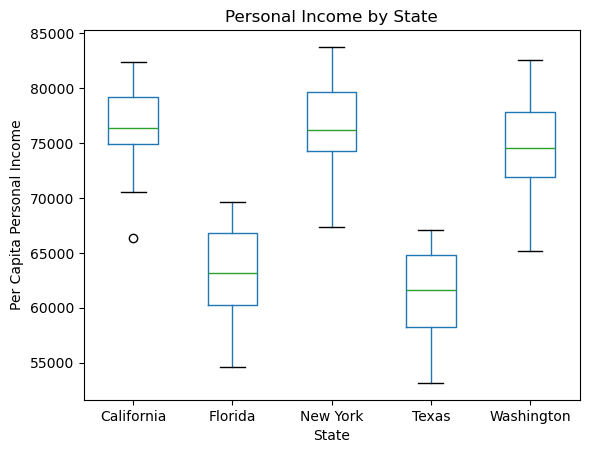

In [50]:
# Create a box plot 
income_df.boxplot(['California','Florida','New York','Texas','Washington'], grid=False) 
# Adding title and labels 
plt.title('Personal Income by State') 

# Suppress the default title 
plt.xlabel('State') 
plt.ylabel('Per Capita Personal Income') 
# Show plot 
plt.show()

In [51]:
# Calculate percent change in income per capita
income_df['US % Change'] = income_df['United States'].pct_change()
income_df['CA % Change'] = income_df['California'].pct_change()
income_df['FL % Change'] = income_df['Florida'].pct_change()
income_df['NY % Change'] = income_df['New York'].pct_change()
income_df['TX % Change'] = income_df['Texas'].pct_change()
income_df['WA % Change'] = income_df['Washington'].pct_change()

# Filter these columns into a new dataframe
income_pc = income_df[['US % Change','CA % Change','FL % Change','NY % Change','TX % Change','WA % Change']]

# Remove PC change columns from income_df
income_df = income_df.iloc[:,0:9]

In [69]:
# Display summary statistics for % Change in personal income per capita
income_pc.describe()

,US % Change,CA % Change,FL % Change,NY % Change,TX % Change,WA % Change
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.015797,0.015075,0.017141,0.015315,0.016387,0.016469
std,0.039873,0.033396,0.042086,0.038847,0.040805,0.035906
min,-0.051092,-0.040619,-0.053515,-0.045434,-0.050942,-0.036108
25%,0.006094,0.001092,0.005200,0.003121,0.005974,0.002385
50%,0.010295,0.009406,0.011674,0.008842,0.010793,0.012936
75%,0.013837,0.017122,0.020179,0.018586,0.020492,0.019459
max,0.126048,0.105671,0.139592,0.121387,0.135828,0.116040


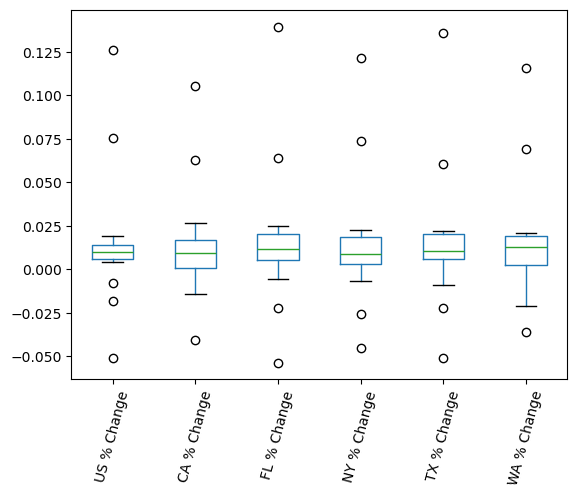

In [70]:
income_pc.iloc[1:,:].boxplot(['US % Change','CA % Change','FL % Change','NY % Change','TX % Change','WA % Change'],grid=False)
plt.xticks(rotation=75)
plt.show()

In [71]:
# Median is better suited to summarize percent change data.
income_pc.iloc[1:,:].median()

US % Change    0.010295
CA % Change    0.009406
FL % Change    0.011674
NY % Change    0.008842
TX % Change    0.010793
WA % Change    0.012936
dtype: float64

In [77]:
# Plot Personal Income Per Capita
plt.figure(figsize=(10, 6))

for state in ['California', 'Florida', 'New York', 'Texas', 'Washington']:
    plt.plot(income_df['Quarters'], income_df[state], marker='o', label=state)

plt.title("Personal Income Per Capita, by state, 2020-2023")
plt.xlabel("Quarters")
plt.ylabel("Personal Income (Per Capita)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

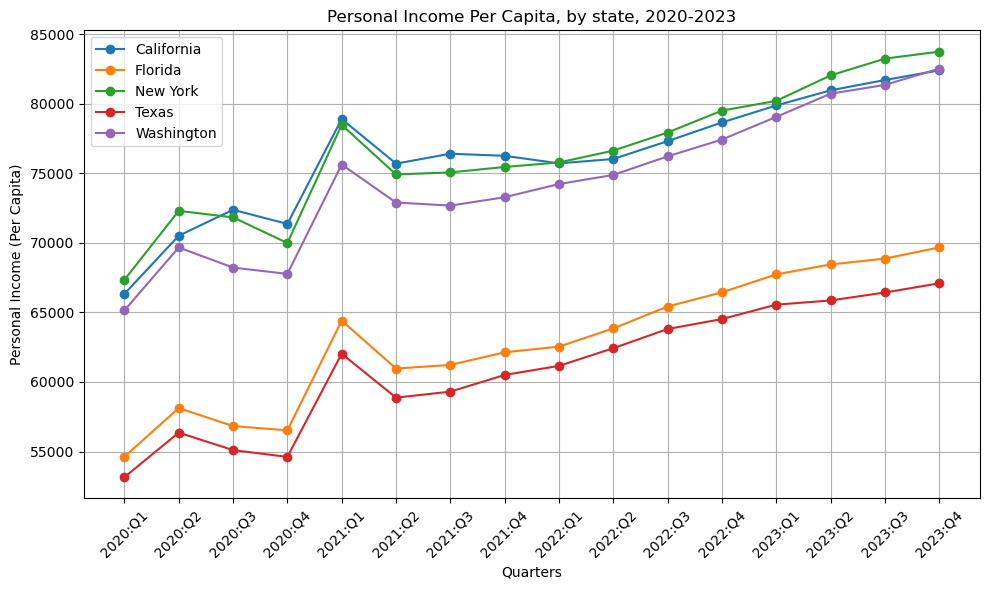

In [78]:
# Display plot
plt.show()

### Poverty Rate
We were unable to source monthly or quarterly poverty data. Below is annual data for our selected states. Due to the limited dataset, we decided to only demonstrate simple changes in poverty rate.

In [79]:
# Sort poverty_df by state and year
poverty_df = poverty_df.sort_values(['State','Year']).reset_index(drop=True)
# Display
poverty_df

,State,Year,Population Below Poverty Level (Estimate),Poverty Rate
0,California,2020,4853434,0.126
1,California,2021,4733036,0.123
2,California,2022,4670324,0.122
3,California,2023,4588687,0.120
4,Florida,2020,2772939,0.133
5,Florida,2021,21368535,0.131
6,Florida,2022,2762679,0.127
7,Florida,2023,2729519,0.123
8,New York,2020,2581048,0.136
9,New York,2021,2688587,0.139


In [80]:
# Print mean poverty rate for selected period
for state in poverty_df['State'].unique():
    print(f"The mean poverty rate in {state} for 2020-2023 was {round(poverty_df[poverty_df['State'] == state]['Poverty Rate'].mean(),4)}")


The mean poverty rate in California for 2020-2023 was 0.1228
The mean poverty rate in Florida for 2020-2023 was 0.1285
The mean poverty rate in New York for 2020-2023 was 0.14
The mean poverty rate in Texas for 2020-2023 was 0.1402
The mean poverty rate in Washington for 2020-2023 was 0.101
